In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy.stats import expon

In [23]:
path =  'Data/RENA.PA/'

files = sorted([i for i in os.listdir(path) if 'quotes' in i])

df_list = [pd.read_csv(path + file,
                 parse_dates=True,index_col='ts').drop('Unnamed: 0',axis=1) for file in files]


In [11]:
path =  'Data/RENA.PA/'

files = sorted([i for i in os.listdir(path) if 'trades' in i])

df_list_trades = [pd.read_csv(path + file,
                 parse_dates=True,index_col='ts').drop('Unnamed: 0',axis=1) for file in files]


## 1. Bid price, ask price, mid price and weighted mid-price on a few minutes of the sample.

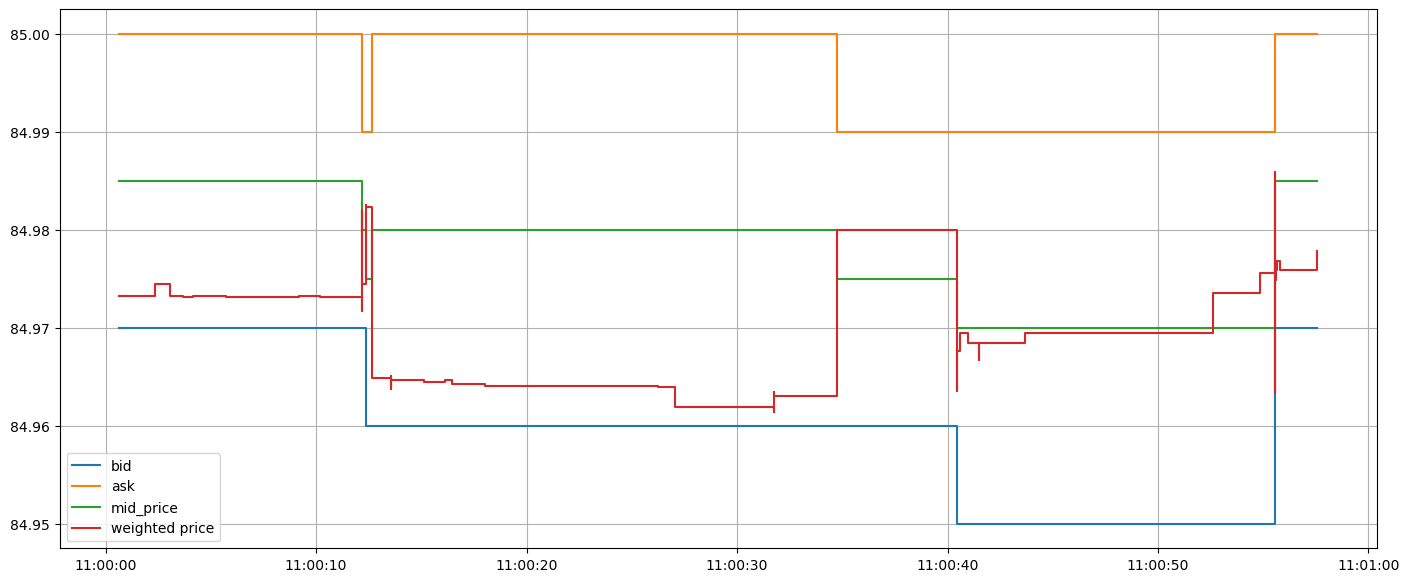

In [4]:
start = pd.to_datetime("2017-01-02 11:00:00")
end = pd.to_datetime("2017-01-02 11:01:00")

data = df_list[0]
data = data[(data.index> start) & (data.index<end)]
bid = data['bp1']
ask = data['ap1']
mid_price = (ask + bid)/2
weighted_price = (ask *data['bq1'] + bid * data['aq1'])/ (data['aq1']+data['bq1'])

plt.figure(figsize=(17,7))
plt.step(bid.index,bid.values,label='bid')
plt.step(ask.index,ask.values,label='ask')
plt.step(mid_price.index,mid_price.values,label='mid_price')
plt.step(weighted_price.index,weighted_price.values,label='weighted price')
plt.grid()
plt.legend()
plt.show()

## 2. Spread distribution : histogram of the spread distribution in event time and then in calendar time.

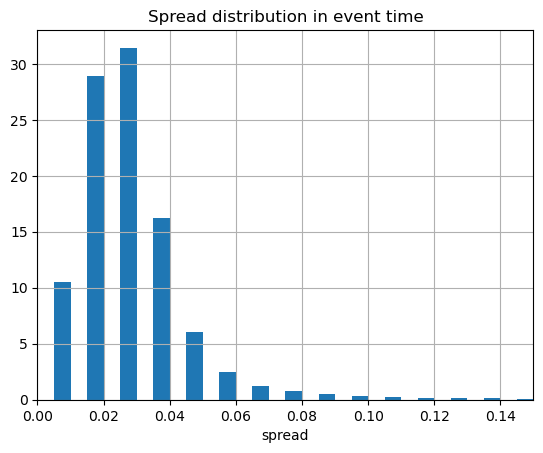

In [6]:
spreads = np.concatenate([(df['ap1'] - df['bp1']).values for df in df_list])

plt.hist(spreads,bins=np.arange(np.min(spreads)-0.005, np.max(spreads)+0.01,step=0.01), density = True ,width=0.005,align='mid')
plt.grid()
plt.xlabel('spread')
plt.title('Spread distribution in event time')
plt.xlim(0,0.15)
plt.show()

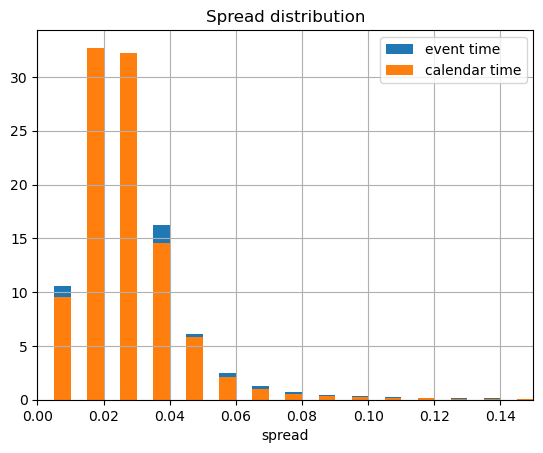

In [8]:
spreads_calendar = np.concatenate([(df['ap1'] - df['bp1']).values[:-1] for df in df_list])
time = np.concatenate([np.diff(df.index.map(pd.Timestamp.timestamp)) for df in df_list])

plt.hist(spreads, bins=np.arange(np.min(spreads)-0.005, np.max(spreads)+0.01,step=0.01),  density = True, width=0.005,align='mid', label = 'event time')
plt.hist(spreads_calendar,weights =time , bins=np.arange(np.min(spreads)-0.005, np.max(spreads)+0.01,step=0.01), density = True, width=0.005,align='mid', label = 'calendar time')

plt.grid()
plt.title('Spread distribution')
plt.xlabel('spread')
plt.legend()
plt.xlim(0,0.15)
plt.show()

On remarque que l'allure générale de la distribution reste la même, mais on note que les probabilités données par la distribution en temps réel (calendar time) pour les spreads compris entre 0.02 et 0.04 sont plus importantes que celles données par la distribution en temps d'évènement. Et inversement, cette dernière donnent des probabilités plus importantes pour les autres spreads.

## 3. Imbalance and trading activity : average mid-price movement as a function of the observed imbalance before the price movement

In [9]:
def imb(qb,qa):
    return (qb-qa)/(qb+qa)

def mid_price(qb,qa):
    return (qb+qa)/2

imbalance = np.concatenate([imb(df['bq1'],df['aq1'])[:-1] for df in df_list])

mid_price = np.concatenate([mid_price(df['bq1'],df['aq1'])[:-1] for df in df_list])

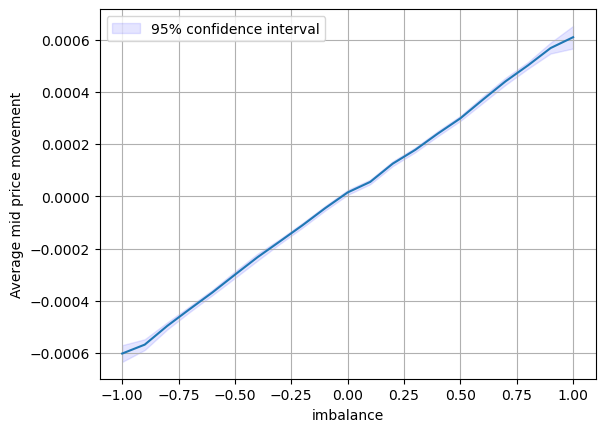

In [10]:
imbalance = np.round(np.concatenate([((df['bq1']-df['aq1'])/(df['bq1']+df['aq1'])).to_numpy() for df in df_list]), 1)[:-1]
mid_price = np.concatenate([((df['bp1']+df['ap1'])/2).to_numpy() for df in df_list])
mid_price_mvt = mid_price[1:]-mid_price[:-1]
unique = np.unique(imbalance)

avg_mid_price_mvt = []
std_mid_price_mvt = []
count = []

for imb in unique:
    indices = np.argwhere(imbalance==imb)[:, 0]
    avg_mid_price_mvt.append(np.mean(mid_price_mvt[indices]))
    std_mid_price_mvt.append(np.std(mid_price_mvt[indices]))
    count.append(len(indices))
    
avg_mid_price_mvt = np.array(avg_mid_price_mvt)
std_mid_price_mvt = np.array(std_mid_price_mvt)
count = np.array(count)

plt.plot(unique,avg_mid_price_mvt)
plt.fill_between(unique, avg_mid_price_mvt - 1.96*std_mid_price_mvt/np.sqrt(count), 
                     avg_mid_price_mvt + 1.96*std_mid_price_mvt/np.sqrt(count), 
                 color='b', 
                 alpha=.1, 
                 label="95% confidence interval")
plt.legend()
plt.grid()
plt.xlabel('imbalance')
plt.ylabel('Average mid price movement')
plt.show()

La moyenne du mouvement du mid price est une fonction croissante en l'imbalance. Lorsque l'imbalance vaut zéro, la moyenne du mouvement du mid price est quasi nulle. On peut dire que l'imbalance contrôle le sens de mouvement du mid price. 

## 4. Autocorrelation of trade signs. Signing the trades of the sample using a tick test and plotting the autocorrelation of the trade signs.

In [12]:
Signs = [1]
price = df_list_trades[0]['price'][0]
for df in df_list_trades:
    for i in range(len(df.index)):
        if df['price'][i]>price:
            Signs.append(1)
        elif df['price'][i]<price:
            Signs.append(-1)
        else:
            Signs.append(Signs[-1])
        price = df['price'][i]

Signs = np.array(Signs[1:])

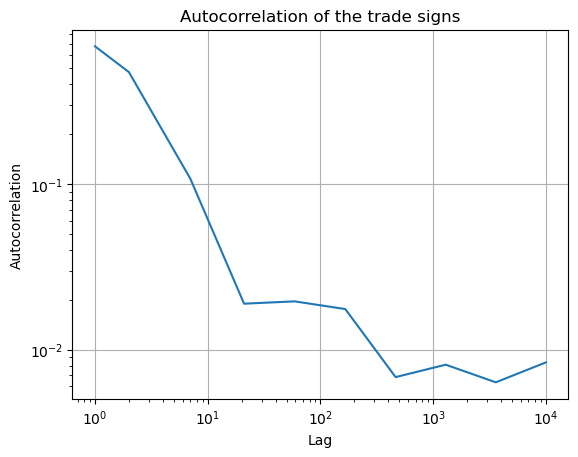

In [13]:
lags = np.logspace(0, 4, 10).astype('int')
acorr = [pd.Series(Signs).autocorr(lag=lag) for lag in lags]
plt.plot(lags, acorr)

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

plt.title("Autocorrelation of the trade signs")

plt.grid()

plt.show()

La figure d'autocorrélation ci-dessus montre un effet de mémoire longue sur le signe des trades. Au bout de 300 trades, l'autocorrélation est encore > 0.01 et ne décroit pas significativement au delà de 300 trades.

## 5. Average shape of the LOB : bar plot of the average shape of the LOB in event time and then in calendar time.

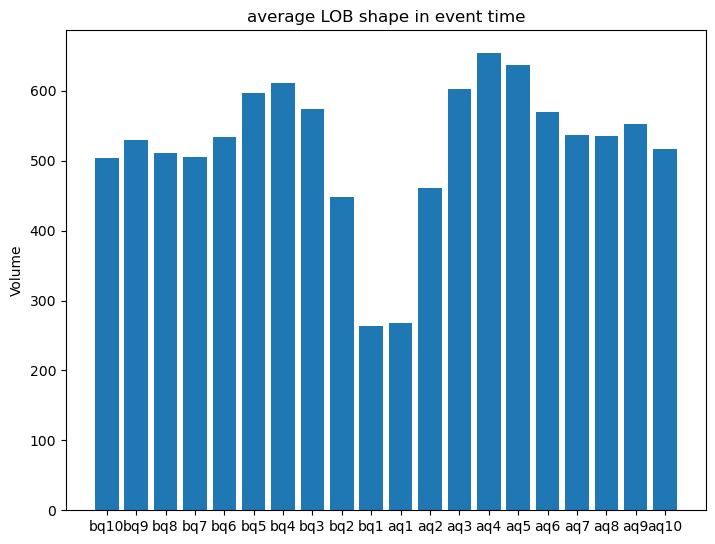

In [27]:
labels = ['bq'+str(i) for i in range(10, 0, -1)] + ['aq' + str(i) for i in range(1, 11)]
values = []

for i in range(10, 0, -1):
    bids = np.concatenate([df['bq'+str(i)].values for df in df_list])
    values.append(np.mean(bids))
    
for i in range(1, 11):
    asks = np.concatenate([df['aq'+str(i)].values for df in df_list])
    values.append(np.mean(asks))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, values)
plt.title('average LOB shape in event time')
plt.ylabel('Volume')
plt.show()

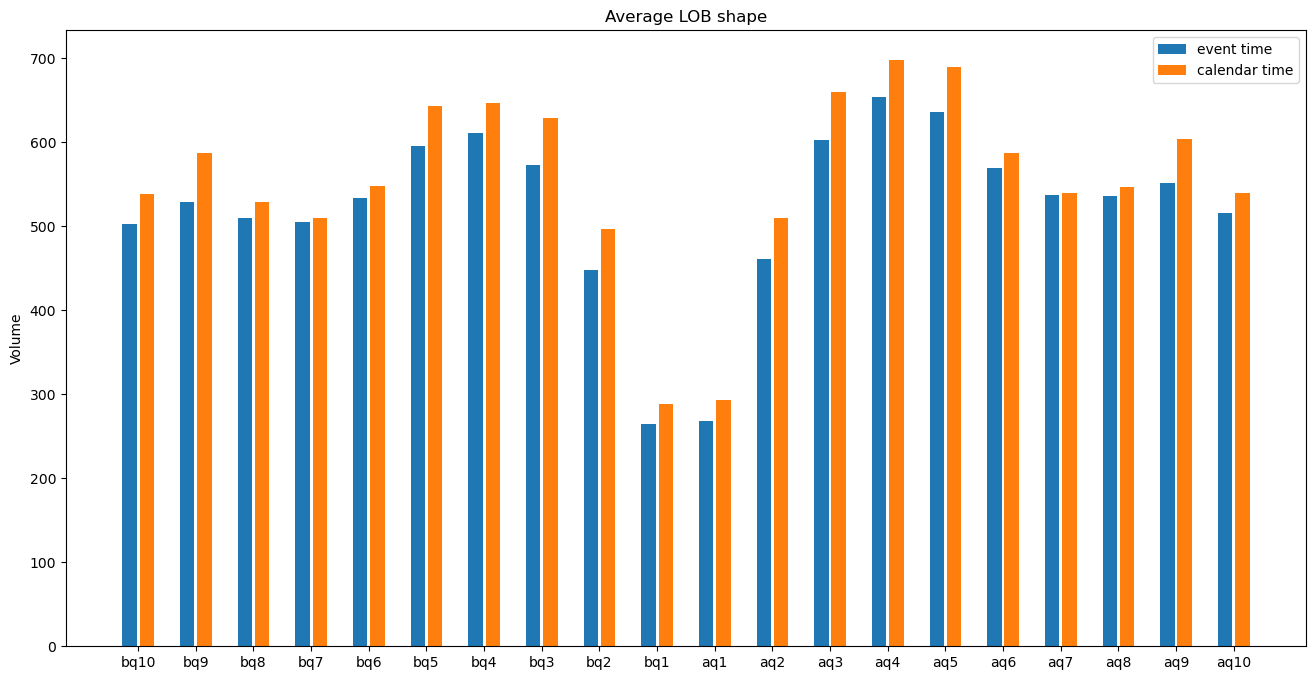

In [26]:
time = np.concatenate([np.diff(df.index.map(pd.Timestamp.timestamp)) for df in df_list])
s = np.sum(time)

labels = ['bq'+str(i) for i in range(10, 0, -1)] + ['aq' + str(i) for i in range(1, 11)]
values_calendar = []

X_axis = np.arange(len(labels))

for i in range(10, 0, -1):
    bids = np.concatenate([df['bq'+str(i)].values[:-1] for df in df_list])
    values_calendar.append(np.sum(bids*time)/s)
    
for i in range(1, 11):
    asks = np.concatenate([df['aq'+str(i)].values[:-1] for df in df_list])
    values_calendar.append(np.sum(asks*time)/s)
    
plt.figure(figsize=(16,8))
plt.bar(X_axis - 0.15, values, 0.25, label = 'event time')
plt.bar(X_axis + 0.15, values_calendar, 0.25, label = 'calendar time')
  
plt.xticks(X_axis, labels)
plt.ylabel("Volume")
plt.title("Average LOB shape")
plt.legend()
plt.show()

On note que la moyenne pondérée des volumes donnée par calendar time est supérieure à celle donnée par event time. Ceci est vrai pour tous les bids et les asks. On remarque également que les maximas du volume se situent autour du bid 4 et du ask 4.